In [52]:
%matplotlib notebook
import cvxpy as cp
import dccp
import torch
import numpy as np
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.metrics import zero_one_loss, confusion_matrix
from scipy.io import arff
import pandas as pd
import time
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.patches as mpatches
import json
import random
import math
import os, psutil
from datetime import datetime

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
np.random.seed(0)

XDIM = 11
COST = 1/XDIM
TRAIN_SLOPE = 1
EVAL_SLOPE = 5
X_LOWER_BOUND = -10
X_UPPER_BOUND = 10

# Utils

In [53]:
def split_data(X, Y, percentage):
    num_val = int(len(X)*percentage)
    return X[num_val:], Y[num_val:], X[:num_val], Y[:num_val]

def shuffle(X, Y):
    data = torch.cat((X, Y), 1)
    data = data[torch.randperm(data.size()[0])]
    X = data[:, :2]
    Y = data[:, 2]
    return X, Y

def conf_mat(Y1, Y2):
    num_of_samples = len(Y1)
    mat = confusion_matrix(Y1, Y2, labels=[-1, 1])*100/num_of_samples
    acc = np.trace(mat)
    return mat, acc

def calc_accuracy(Y, Ypred):
    num = len(Y)
    temp = Y - Ypred
    acc = len(temp[temp == 0])*1./num
    return acc

# Dataset

In [54]:
def gen_custom_data(N, pos_ranges, neg_ranges):
    """
    pos_ranges: a tuple of tensors of length XDIM.
    (scales tensor, offsets tensor)
    """
    torch.manual_seed(0)
    np.random.seed(0)
    pos_samples_num = N//2
    neg_samples_num = N - pos_samples_num
    posX = torch.rand((pos_samples_num, XDIM))*pos_ranges[0] + pos_ranges[1]
    negX = torch.rand((neg_samples_num, XDIM))*neg_ranges[0] + neg_ranges[1]
    
    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.ones(len(posX)), -torch.ones(len(negX))), 0), 1)

    X, Y = shuffle(X, Y)
    return X, Y

def load_credit_default_data():
    torch.manual_seed(0)
    np.random.seed(0)
    url = 'https://raw.githubusercontent.com/ustunb/actionable-recourse/master/examples/paper/data/credit_processed.csv'
    df = pd.read_csv(url)
    df["NoDefaultNextMonth"].replace({0: -1}, inplace=True)
    df = df.sample(frac=1).reset_index(drop=True)

    df = df.drop(['Married', 'Single', 'Age_lt_25', 'Age_in_25_to_40', 'Age_in_40_to_59', 'Age_geq_60'], axis = 1)

    scaler = StandardScaler()
    df.loc[:, df.columns != "NoDefaultNextMonth"] = scaler.fit_transform(df.drop("NoDefaultNextMonth", axis=1))

    fraud_df = df.loc[df["NoDefaultNextMonth"] == -1]
    non_fraud_df = df.loc[df["NoDefaultNextMonth"] == 1][:6636]

    normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

    # Shuffle dataframe rows
    df = normal_distributed_df.sample(frac=1).reset_index(drop=True)

    Y, X = df.iloc[:, 0].values, df.iloc[:, 1:].values
    return torch.from_numpy(X), torch.from_numpy(Y)

    
def gen_sklearn_data(N, informative_frac=1, shift_range=1, scale_range=1, noise_frac=0.01):
    torch.manual_seed(0)
    np.random.seed(0)
    n_informative = int(informative_frac*XDIM)
    n_redundant = XDIM - n_informative
    shift_arr = shift_range*np.random.randn(XDIM)
    scale_arr = scale_range*np.random.randn(XDIM)
    X, Y = make_classification(n_samples=N, n_features=XDIM, n_informative=n_informative, n_redundant=n_redundant,
                               flip_y=noise_frac, shift=shift_arr, scale=scale_arr, random_state=0)
    Y[Y == 0] = -1
    return torch.from_numpy(X), torch.from_numpy(Y)

def gen_custom_normal_data(N, pos_mean, pos_std, neg_mean, neg_std):
    torch.manual_seed(0)
    np.random.seed(0)
    pos_samples_num = N//2
    neg_samples_num = N - pos_samples_num
    posX = torch.randn((pos_samples_num, XDIM))*pos_std + pos_mean
    negX = torch.randn((neg_samples_num, XDIM))*neg_std + neg_mean
    
    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.ones(len(posX)), -torch.ones(len(negX))), 0), 1)

    X, Y = shuffle(X, Y)
    return X, Y


# CCP classes

In [55]:
class CCP:
    def __init__(self, x_dim, funcs):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.xt = cp.Parameter(x_dim)
        self.r = cp.Parameter(x_dim)
        self.w = cp.Parameter(x_dim)
        self.b = cp.Parameter(1)
        self.slope = cp.Parameter(1)

        target = self.x@self.f_derivative(self.xt, self.w, self.b, self.slope)-self.g(self.x, self.w, self.b, self.slope)-self.c(self.x, self.r)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        self.prob = cp.Problem(cp.Maximize(target), constraints)
        
    def ccp(self, r):
        """
        numpy to numpy
        """
        self.xt.value = r
        self.r.value = r
        result = self.prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        cnt = 0
        while diff > 0.0001 and cnt < 10:
            cnt += 1
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)
        return self.x.value
    
    def optimize_X(self, X, w, b, slope):
        """
        tensor to tensor
        """
        w = w.detach().numpy()
        b = b.detach().numpy()
        slope = np.full(1, slope)
        X = X.numpy()
        
        self.w.value = w
        self.b.value = b
        self.slope.value = slope
        
        return torch.stack([torch.from_numpy(self.ccp(x)) for x in X])

In [56]:
class DELTA():
    
    def __init__(self, x_dim, funcs):
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.r = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.f_der = cp.Parameter(x_dim, value = np.random.randn(x_dim))

        target = self.x@self.f_der-self.g(self.x, self.w, self.b, TRAIN_SLOPE)-self.c(self.x, self.r)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.r, self.w, self.b, self.f_der],
                                variables=[self.x])
        
        
    def optimize_X(self, X, w, b, F_DER):
        return self.layer(X, w, b, F_DER)[0]

# Gain & Cost functions

In [57]:
def score(x, w, b):
    return x@w + b

def f(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) + 1)]), 2)

def g(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) - 1)]), 2)

def c(x, r):
    return COST*cp.sum_squares(x-r)

def f_derivative(x, w, b, slope):
    return 0.5*cp.multiply(slope*((slope*score(x, w, b) + 1)/cp.sqrt((slope*score(x, w, b) + 1)**2 + 1)), w)

funcs = {"f": f, "g": g, "f_derivative": f_derivative, "c": c, "score": score}

# Data generation

In [58]:
N = 400
X, Y = load_credit_default_data()
X, Y = X[:3000], Y[:3000]
print(len(X[0]))
assert(len(X[0]) == XDIM)
X, Y, Xval, Yval = split_data(X, Y, 0.5)
Xval, Yval, Xtest, Ytest = split_data(Xval, Yval, 0.5)

print("percent of positive samples: {}%".format(100 * len(Y[Y == 1]) / len(Y)))
visualize_data(X, Y)

11
percent of positive samples: 49.266666666666666%


# Model

In [59]:
class MyStrategicModel(torch.nn.Module):
    def __init__(self, x_dim, funcs, train_slope, eval_slope, strategic=False, lamb=0):
        torch.manual_seed(0)
        np.random.seed(0)
        super(MyStrategicModel, self).__init__()
        self.x_dim = x_dim
        self.train_slope, self.eval_slope = train_slope, eval_slope
        self.w = torch.nn.parameter.Parameter(math.sqrt(1/x_dim)*(1-2*torch.rand(x_dim, dtype=torch.float64, requires_grad=True)))
        self.b = torch.nn.parameter.Parameter(torch.rand(1, dtype=torch.float64, requires_grad=True))
        self.sigmoid = torch.nn.Sigmoid()
        self.strategic = strategic
        self.lamb = lamb
        self.ccp = CCP(x_dim, funcs)
        self.delta = DELTA(x_dim, funcs)

    def forward(self, X, evaluation=False):
        slope = self.eval_slope if evaluation else self.train_slope
        
        XT = self.ccp.optimize_X(X, self.w, self.b, slope)
        F_DER = self.get_f_ders(XT, slope)
        X_opt = self.delta.optimize_X(X, self.w, self.b, F_DER) # Xopt should equal to XT but we do it again for the gradients
        recouse = self.calc_recourse(X, X_opt)
        
        if self.strategic:
            output = self.score(X_opt)
        else:
            output = self.score(X)        
        
        return output, recouse
    
    def optimize_X(self, X, evaluation=False):
        slope = self.eval_slope if evaluation else self.train_slope
        return self.ccp.optimize_X(X, self.w, self.b, slope)
    
    def score(self, x):
        return x@self.w + self.b
    
    def get_f_ders(self, XT, slope):
        return torch.stack([0.5*slope*((slope*self.score(xt) + 1)/torch.sqrt((slope*self.score(xt) + 1)**2 + 1))*self.w for xt in XT])

    def evaluate(self, X, Y):
        scores, _ = self.forward(X, evaluation=True)
        Y_pred = torch.sign(scores)
        num = len(Y)
        temp = Y - Y_pred
        acc = len(temp[temp == 0])*1./num        
        return acc
        
    def calc_recourse(self, X, X_opt):      
        S = self.score(X)
        is_neg = self.sigmoid(-S)
        
        S = self.score(X_opt)
        is_not_able_to_be_pos = self.sigmoid(-S)
        
        recourse_penalty = is_neg * is_not_able_to_be_pos
        return 1 - torch.mean(recourse_penalty)
    
    def loss(self, Y, Y_pred, recourse):
        if self.lamb > 0:
            return torch.mean(torch.clamp(1 - Y_pred * Y, min=0)) + self.lamb*(1 - recourse)
        else:
            return torch.mean(torch.clamp(1 - Y_pred * Y, min=0))
        
    
    def save_model(self, X, Y, Xval, Yval, Xtest, Ytest, train_errors, val_errors, train_losses, val_losses, val_recourses, info, path, comment=None):
        if comment is not None:
            path += "_____" + comment
            
        filename = path + "/model.pt"
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
        torch.save(self.state_dict(), filename)
        
        pd.DataFrame(X.numpy()).to_csv(path + '/X.csv')
        pd.DataFrame(Y.numpy()).to_csv(path + '/Y.csv')
        pd.DataFrame(Xval.numpy()).to_csv(path + '/Xval.csv')
        pd.DataFrame(Yval.numpy()).to_csv(path + '/Yval.csv')
        pd.DataFrame(Xval.numpy()).to_csv(path + '/Xtest.csv')
        pd.DataFrame(Yval.numpy()).to_csv(path + '/Ytest.csv')
        
        pd.DataFrame(np.array(train_errors)).to_csv(path + '/train_errors.csv')
        pd.DataFrame(np.array(val_errors)).to_csv(path + '/val_errors.csv')
        pd.DataFrame(np.array(train_losses)).to_csv(path + '/train_losses.csv')
        pd.DataFrame(np.array(val_losses)).to_csv(path + '/val_losses.csv')
        pd.DataFrame(np.array(val_recourses)).to_csv(path + '/val_recourses.csv')
        
        with open(path + "/info.txt", "w") as f:
            f.write(info)
    
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()
    
    def fit(self, X, Y, Xval, Yval, Xtest, Ytest, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, verbose=False, callback=None, calc_train_errors=False, comment=None):
        train_dset = TensorDataset(X, Y)
        train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
        opt = opt(self.parameters(), **opt_kwargs)

        train_losses = []
        val_losses = []
        train_errors = []
        val_errors = []
        val_recourses = []
        
        best_val_error = 1
        best_val_recourse = 1
        consecutive_no_improvement = 0
        now = datetime.now()
        path = "C:/Users/sagil/Desktop/nir project/models/recourse/" + now.strftime("%d-%m-%Y_%H-%M-%S")

        total_time = time.time()
        for epoch in range(epochs):
            t1 = time.time()
            batch = 1
            train_losses.append([])
            train_errors.append([])
            for Xbatch, Ybatch in train_loader:
                opt.zero_grad()
                Ybatch_pred, recourse = self.forward(Xbatch)
                l = self.loss(Ybatch, Ybatch_pred, recourse)
                l.backward()
                opt.step()
                train_losses[-1].append(l.item())
                if calc_train_errors:
                    with torch.no_grad():
                        e = self.evaluate(Xbatch, Ybatch)
                        train_errors[-1].append(1-e)
                if verbose:
                    print("batch %03d / %03d | loss: %3.5f | recourse: %3.5f" %
                          (batch, len(train_loader), np.mean(train_losses[-1]), recourse))
                batch += 1
                if callback is not None:
                    callback()

            with torch.no_grad():
                Yval_pred, val_recourse = self.forward(Xval) #, evaluation=True)
                val_recourse = val_recourse.item()
                val_loss = self.loss(Yval, Yval_pred, val_recourse).item()
                val_losses.append(val_loss)
                val_error = 1-self.evaluate(Xval, Yval)
                val_errors.append(val_error)
                val_recourses.append(val_recourse)
                if val_error < best_val_error:
                    consecutive_no_improvement = 0
                    best_val_error = val_error
                    if self.strategic:
                        info = "training time in seconds: {}\nepoch: {}\nbatch size: {}\ntrain slope: {}\neval slope: {}\nlearning rate: {}\nvalidation loss: {}\nvalidation error: {}\nrecourse: {}".format(
                        time.time()-total_time, epoch, batch_size, self.train_slope, self.eval_slope, opt_kwargs["lr"], val_loss, val_error, val_recourse)
                        self.save_model(X, Y, Xval, Yval, Xtest, Ytest, train_errors, val_errors, train_losses, val_losses, val_recourses, info, path, comment)
                        print("model saved!")
                else:
                    consecutive_no_improvement += 1
                    if consecutive_no_improvement >= 4:
                        break
                
            t2 = time.time()
            if verbose:
                print("----- epoch %03d / %03d | time: %03d sec | loss: %3.5f | recourse: %3.5f | err: %3.5f" % (epoch + 1, epochs, t2-t1, val_losses[-1], val_recourses[-1], val_errors[-1]))
        print("training time: {} seconds".format(time.time()-total_time)) 
        return train_errors, val_errors, train_losses, val_losses

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Train

In [ ]:
EPOCHS = 10
BATCH_SIZE = 64

x_dim = XDIM

# # non-strategic classification
# print("---------- training non-strategically----------")
# non_strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=False)

# fit_res_non_strategic = non_strategic_model.fit(X, Y, Xval, Yval, Xtest, Ytest,
#                                 opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
#                                 batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False)


# strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True, lamb=10)

# fit_res_strategic = strategic_model.fit(X, Y, Xval, Yval, Xtest, Ytest,
#                                 opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
#                                 batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False,
#                                 comment="recourse_default")


lambda_range = torch.logspace(start=-1, end=0.5, steps=15)
random.shuffle(list(lambda_range))
lambda_range = torch.Tensor(lambda_range)
print(lambda_range)
for lamb in lambda_range:

    # strategic classification
    print("---------- training strategically----------")
    print("lambda: ", lamb.item())
    strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True, lamb=lamb)

    fit_res_strategic = strategic_model.fit(X, Y, Xval, Yval, Xtest, Ytest,
                                    opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-2)},
                                    batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False,
                                    comment="recourse_" + str(lamb.item()))

    

tensor([0.1000, 0.1280, 0.1638, 0.2096, 0.2683, 0.3433, 0.4394, 0.5623, 0.7197,
        0.9211, 1.1788, 1.5086, 1.9307, 2.4709, 3.1623])
---------- training strategically----------
lambda:  0.1


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 0.83015 | recourse: 0.85112
batch 002 / 024 | loss: 0.92431 | recourse: 0.88417
batch 003 / 024 | loss: 0.91303 | recourse: 0.87433
batch 004 / 024 | loss: 0.91197 | recourse: 0.86607
batch 005 / 024 | loss: 0.92433 | recourse: 0.82950
batch 006 / 024 | loss: 0.91730 | recourse: 0.82418
batch 007 / 024 | loss: 0.90292 | recourse: 0.78580
batch 008 / 024 | loss: 0.87665 | recourse: 0.77054
batch 009 / 024 | loss: 0.87359 | recourse: 0.74767
batch 010 / 024 | loss: 0.85975 | recourse: 0.74094
batch 011 / 024 | loss: 0.83669 | recourse: 0.71806
batch 012 / 024 | loss: 0.83435 | recourse: 0.73710
batch 013 / 024 | loss: 0.83085 | recourse: 0.79241
batch 014 / 024 | loss: 0.82559 | recourse: 0.67842
batch 015 / 024 | loss: 0.81581 | recourse: 0.71249
batch 016 / 024 | loss: 0.81312 | recourse: 0.68672
batch 017 / 024 | loss: 0.80410 | recourse: 0.67508
batch 018 / 024 | loss: 0.80741 | recourse: 0.64701
batch 019 / 024 | loss: 0.80321 | recourse: 0.65878
batch 020 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


----- epoch 002 / 010 | time: 508 sec | loss: 0.70928 | recourse: 0.61802 | err: 0.30533
batch 001 / 024 | loss: 0.72264 | recourse: 0.61249
batch 002 / 024 | loss: 0.77895 | recourse: 0.64389
batch 003 / 024 | loss: 0.77647 | recourse: 0.64165
batch 004 / 024 | loss: 0.75157 | recourse: 0.67860
batch 005 / 024 | loss: 0.77051 | recourse: 0.63189
batch 006 / 024 | loss: 0.76286 | recourse: 0.68778
batch 007 / 024 | loss: 0.77012 | recourse: 0.70170
batch 008 / 024 | loss: 0.75635 | recourse: 0.69974
batch 009 / 024 | loss: 0.75271 | recourse: 0.65749
batch 010 / 024 | loss: 0.74886 | recourse: 0.66200
batch 011 / 024 | loss: 0.73849 | recourse: 0.67939
batch 012 / 024 | loss: 0.73872 | recourse: 0.62014
batch 013 / 024 | loss: 0.72545 | recourse: 0.61889
batch 014 / 024 | loss: 0.71953 | recourse: 0.58887
batch 015 / 024 | loss: 0.71025 | recourse: 0.61174
batch 016 / 024 | loss: 0.71255 | recourse: 0.56237
batch 017 / 024 | loss: 0.70432 | recourse: 0.66480
batch 018 / 024 | loss: 0.7

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 0.83432 | recourse: 0.85112
batch 002 / 024 | loss: 0.92802 | recourse: 0.88417
batch 003 / 024 | loss: 0.91680 | recourse: 0.87456
batch 004 / 024 | loss: 0.91600 | recourse: 0.86658
batch 005 / 024 | loss: 0.92871 | recourse: 0.83016
batch 006 / 024 | loss: 0.92179 | recourse: 0.82475
batch 007 / 024 | loss: 0.90768 | recourse: 0.78639
batch 008 / 024 | loss: 0.88169 | recourse: 0.77105
batch 009 / 024 | loss: 0.87884 | recourse: 0.74844
batch 010 / 024 | loss: 0.86522 | recourse: 0.74172
batch 011 / 024 | loss: 0.84225 | recourse: 0.71932
batch 012 / 024 | loss: 0.84025 | recourse: 0.73895
batch 013 / 024 | loss: 0.83680 | recourse: 0.79361
batch 014 / 024 | loss: 0.83181 | recourse: 0.67990
batch 015 / 024 | loss: 0.82229 | recourse: 0.71420
batch 016 / 024 | loss: 0.81990 | recourse: 0.68823
batch 017 / 024 | loss: 0.81110 | recourse: 0.67747
batch 018 / 024 | loss: 0.81459 | recourse: 0.64930
batch 019 / 024 | loss: 0.81056 | recourse: 0.66131
batch 020 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


model saved!
----- epoch 001 / 010 | time: 454 sec | loss: 0.72040 | recourse: 0.65846 | err: 0.30533
batch 001 / 024 | loss: 0.69056 | recourse: 0.69441
batch 002 / 024 | loss: 0.79061 | recourse: 0.65520
batch 003 / 024 | loss: 0.76276 | recourse: 0.64427
batch 004 / 024 | loss: 0.75492 | recourse: 0.66918
batch 005 / 024 | loss: 0.77517 | recourse: 0.74764
batch 006 / 024 | loss: 0.80150 | recourse: 0.63664
batch 007 / 024 | loss: 0.78379 | recourse: 0.62078
batch 008 / 024 | loss: 0.77890 | recourse: 0.65192
batch 009 / 024 | loss: 0.74870 | recourse: 0.62454
batch 010 / 024 | loss: 0.73818 | recourse: 0.62784
batch 011 / 024 | loss: 0.72718 | recourse: 0.60329
batch 012 / 024 | loss: 0.71435 | recourse: 0.60025
batch 013 / 024 | loss: 0.71604 | recourse: 0.62990
batch 014 / 024 | loss: 0.70791 | recourse: 0.66744
batch 015 / 024 | loss: 0.69782 | recourse: 0.58336
batch 016 / 024 | loss: 0.69863 | recourse: 0.68264
batch 017 / 024 | loss: 0.70653 | recourse: 0.66903
batch 018 / 02

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 0.83965 | recourse: 0.85112
batch 002 / 024 | loss: 0.93276 | recourse: 0.88417
batch 003 / 024 | loss: 0.92163 | recourse: 0.87487
batch 004 / 024 | loss: 0.92115 | recourse: 0.86725
batch 005 / 024 | loss: 0.93462 | recourse: 0.83129
batch 006 / 024 | loss: 0.92813 | recourse: 0.82621
batch 007 / 024 | loss: 0.91465 | recourse: 0.78800
batch 008 / 024 | loss: 0.88912 | recourse: 0.77250
batch 009 / 024 | loss: 0.88658 | recourse: 0.74984
batch 010 / 024 | loss: 0.87322 | recourse: 0.74290
batch 011 / 024 | loss: 0.85057 | recourse: 0.72050
batch 012 / 024 | loss: 0.84873 | recourse: 0.74036
batch 013 / 024 | loss: 0.84532 | recourse: 0.79551
batch 014 / 024 | loss: 0.84082 | recourse: 0.68293
batch 015 / 024 | loss: 0.83157 | recourse: 0.71753
batch 016 / 024 | loss: 0.82938 | recourse: 0.69105
batch 017 / 024 | loss: 0.82086 | recourse: 0.68088
batch 018 / 024 | loss: 0.82443 | recourse: 0.65247
batch 019 / 024 | loss: 0.82068 | recourse: 0.66359
batch 020 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 002 / 024 | loss: 0.80051 | recourse: 0.65856
batch 003 / 024 | loss: 0.77488 | recourse: 0.64820
batch 004 / 024 | loss: 0.76719 | recourse: 0.67132
batch 005 / 024 | loss: 0.78769 | recourse: 0.75201
batch 006 / 024 | loss: 0.81415 | recourse: 0.64041
batch 007 / 024 | loss: 0.79739 | recourse: 0.62671
batch 008 / 024 | loss: 0.79195 | recourse: 0.65571
batch 009 / 024 | loss: 0.76089 | recourse: 0.62670
batch 010 / 024 | loss: 0.75057 | recourse: 0.63177
batch 011 / 024 | loss: 0.73926 | recourse: 0.60657
batch 012 / 024 | loss: 0.72688 | recourse: 0.60444
batch 013 / 024 | loss: 0.72815 | recourse: 0.63404
batch 014 / 024 | loss: 0.72040 | recourse: 0.67161
batch 015 / 024 | loss: 0.71061 | recourse: 0.58603
batch 016 / 024 | loss: 0.71093 | recourse: 0.68203
batch 017 / 024 | loss: 0.71848 | recourse: 0.66550
batch 018 / 024 | loss: 0.72156 | recourse: 0.69463
batch 019 / 024 | loss: 0.72413 | recourse: 0.66542
batch 020 / 024 | loss: 0.72008 | recourse: 0.62812
batch 021 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 0.84647 | recourse: 0.85112
batch 002 / 024 | loss: 0.93882 | recourse: 0.88417
batch 003 / 024 | loss: 0.92779 | recourse: 0.87526
batch 004 / 024 | loss: 0.92773 | recourse: 0.86811
batch 005 / 024 | loss: 0.94216 | recourse: 0.83276
batch 006 / 024 | loss: 0.93611 | recourse: 0.82792
batch 007 / 024 | loss: 0.92336 | recourse: 0.78975
batch 008 / 024 | loss: 0.89843 | recourse: 0.77431
batch 009 / 024 | loss: 0.89628 | recourse: 0.75192
batch 010 / 024 | loss: 0.88323 | recourse: 0.74463
batch 011 / 024 | loss: 0.86083 | recourse: 0.72232
batch 012 / 024 | loss: 0.85922 | recourse: 0.74239
batch 013 / 024 | loss: 0.85572 | recourse: 0.79723
batch 014 / 024 | loss: 0.85164 | recourse: 0.68605
batch 015 / 024 | loss: 0.84265 | recourse: 0.72102
batch 016 / 024 | loss: 0.84076 | recourse: 0.69419
batch 017 / 024 | loss: 0.83264 | recourse: 0.68556
batch 018 / 024 | loss: 0.83656 | recourse: 0.65716
batch 019 / 024 | loss: 0.83314 | recourse: 0.66850
batch 020 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


model saved!
----- epoch 001 / 010 | time: 485 sec | loss: 0.74750 | recourse: 0.67002 | err: 0.30400
batch 001 / 024 | loss: 0.71541 | recourse: 0.70444
batch 002 / 024 | loss: 0.81178 | recourse: 0.66875
batch 003 / 024 | loss: 0.79046 | recourse: 0.65712
batch 004 / 024 | loss: 0.78343 | recourse: 0.67900
batch 005 / 024 | loss: 0.80313 | recourse: 0.75734
batch 006 / 024 | loss: 0.82919 | recourse: 0.64819
batch 007 / 024 | loss: 0.81268 | recourse: 0.63381
batch 008 / 024 | loss: 0.80658 | recourse: 0.66454
batch 009 / 024 | loss: 0.77787 | recourse: 0.63737
batch 010 / 024 | loss: 0.76810 | recourse: 0.64221
batch 011 / 024 | loss: 0.75722 | recourse: 0.61775
batch 012 / 024 | loss: 0.74547 | recourse: 0.61400
batch 013 / 024 | loss: 0.74637 | recourse: 0.64087
batch 014 / 024 | loss: 0.73901 | recourse: 0.67566
batch 015 / 024 | loss: 0.72927 | recourse: 0.58780
batch 016 / 024 | loss: 0.72936 | recourse: 0.68573
batch 017 / 024 | loss: 0.73635 | recourse: 0.66661
batch 018 / 02

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 0.85520 | recourse: 0.85112
batch 002 / 024 | loss: 0.94658 | recourse: 0.88417
batch 003 / 024 | loss: 0.93567 | recourse: 0.87576
batch 004 / 024 | loss: 0.93612 | recourse: 0.86923
batch 005 / 024 | loss: 0.95188 | recourse: 0.83469
batch 006 / 024 | loss: 0.94651 | recourse: 0.83035
batch 007 / 024 | loss: 0.93483 | recourse: 0.79260
batch 008 / 024 | loss: 0.91055 | recourse: 0.77786
batch 009 / 024 | loss: 0.90906 | recourse: 0.75550
batch 010 / 024 | loss: 0.89644 | recourse: 0.74782
batch 011 / 024 | loss: 0.87424 | recourse: 0.72490
batch 012 / 024 | loss: 0.87262 | recourse: 0.74368
batch 013 / 024 | loss: 0.86877 | recourse: 0.79811
batch 014 / 024 | loss: 0.86492 | recourse: 0.68769
batch 015 / 024 | loss: 0.85611 | recourse: 0.72344
batch 016 / 024 | loss: 0.85454 | recourse: 0.69666
batch 017 / 024 | loss: 0.84692 | recourse: 0.68938
batch 018 / 024 | loss: 0.85143 | recourse: 0.66232
batch 019 / 024 | loss: 0.84819 | recourse: 0.67333
batch 020 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


model saved!
----- epoch 001 / 010 | time: 454 sec | loss: 0.76471 | recourse: 0.67701 | err: 0.30400
batch 001 / 024 | loss: 0.73628 | recourse: 0.71093
batch 002 / 024 | loss: 0.83024 | recourse: 0.67160
batch 003 / 024 | loss: 0.80366 | recourse: 0.65638
batch 004 / 024 | loss: 0.79697 | recourse: 0.68180
batch 005 / 024 | loss: 0.81431 | recourse: 0.75575
batch 006 / 024 | loss: 0.83954 | recourse: 0.65163
batch 007 / 024 | loss: 0.82399 | recourse: 0.63675
batch 008 / 024 | loss: 0.81743 | recourse: 0.67480
batch 009 / 024 | loss: 0.79248 | recourse: 0.65317
batch 010 / 024 | loss: 0.78506 | recourse: 0.65971
batch 011 / 024 | loss: 0.77660 | recourse: 0.64285
batch 012 / 024 | loss: 0.76523 | recourse: 0.63761
batch 013 / 024 | loss: 0.76470 | recourse: 0.66396
batch 014 / 024 | loss: 0.75822 | recourse: 0.68938
batch 015 / 024 | loss: 0.74890 | recourse: 0.59457
batch 016 / 024 | loss: 0.74857 | recourse: 0.68896
batch 017 / 024 | loss: 0.75429 | recourse: 0.66507
batch 018 / 02

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 0.86638 | recourse: 0.85112
batch 002 / 024 | loss: 0.95652 | recourse: 0.88417
batch 003 / 024 | loss: 0.94573 | recourse: 0.87641
batch 004 / 024 | loss: 0.94680 | recourse: 0.87068
batch 005 / 024 | loss: 0.96399 | recourse: 0.83677
batch 006 / 024 | loss: 0.95921 | recourse: 0.83287
batch 007 / 024 | loss: 0.94865 | recourse: 0.79518
batch 008 / 024 | loss: 0.92548 | recourse: 0.78109
batch 009 / 024 | loss: 0.92466 | recourse: 0.75933
batch 010 / 024 | loss: 0.91267 | recourse: 0.75131
batch 011 / 024 | loss: 0.89080 | recourse: 0.72847
batch 012 / 024 | loss: 0.88953 | recourse: 0.74673
batch 013 / 024 | loss: 0.88557 | recourse: 0.80064
batch 014 / 024 | loss: 0.88229 | recourse: 0.69158
batch 015 / 024 | loss: 0.87371 | recourse: 0.72725
batch 016 / 024 | loss: 0.87248 | recourse: 0.69985
batch 017 / 024 | loss: 0.86539 | recourse: 0.69378
batch 018 / 024 | loss: 0.87027 | recourse: 0.66750
batch 019 / 024 | loss: 0.86742 | recourse: 0.67777
batch 020 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


model saved!
----- epoch 001 / 010 | time: 448 sec | loss: 0.78969 | recourse: 0.68709 | err: 0.30267
batch 001 / 024 | loss: 0.76236 | recourse: 0.71963
batch 002 / 024 | loss: 0.85132 | recourse: 0.68196
batch 003 / 024 | loss: 0.83005 | recourse: 0.66739
batch 004 / 024 | loss: 0.82393 | recourse: 0.69257
batch 005 / 024 | loss: 0.84140 | recourse: 0.76389
batch 006 / 024 | loss: 0.86433 | recourse: 0.66389
batch 007 / 024 | loss: 0.84932 | recourse: 0.64600
batch 008 / 024 | loss: 0.84263 | recourse: 0.68224
batch 009 / 024 | loss: 0.81833 | recourse: 0.65927
batch 010 / 024 | loss: 0.81069 | recourse: 0.66578
batch 011 / 024 | loss: 0.80236 | recourse: 0.64658
batch 012 / 024 | loss: 0.79134 | recourse: 0.64435
batch 013 / 024 | loss: 0.79131 | recourse: 0.66836
batch 014 / 024 | loss: 0.78441 | recourse: 0.69630
batch 015 / 024 | loss: 0.77602 | recourse: 0.60804
batch 016 / 024 | loss: 0.77774 | recourse: 0.70588
batch 017 / 024 | loss: 0.78299 | recourse: 0.68389
batch 018 / 02

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 0.88068 | recourse: 0.85112
batch 002 / 024 | loss: 0.96923 | recourse: 0.88417
batch 003 / 024 | loss: 0.95856 | recourse: 0.87723
batch 004 / 024 | loss: 0.96048 | recourse: 0.87253
batch 005 / 024 | loss: 0.97957 | recourse: 0.83979
batch 006 / 024 | loss: 0.97537 | recourse: 0.83628
batch 007 / 024 | loss: 0.96609 | recourse: 0.79916
batch 008 / 024 | loss: 0.94395 | recourse: 0.78508
batch 009 / 024 | loss: 0.94378 | recourse: 0.76400
batch 010 / 024 | loss: 0.93248 | recourse: 0.75588
batch 011 / 024 | loss: 0.91102 | recourse: 0.73373
batch 012 / 024 | loss: 0.91032 | recourse: 0.75177
batch 013 / 024 | loss: 0.90621 | recourse: 0.80410
batch 014 / 024 | loss: 0.90326 | recourse: 0.69803
batch 015 / 024 | loss: 0.89541 | recourse: 0.73269
batch 016 / 024 | loss: 0.89465 | recourse: 0.70504
batch 017 / 024 | loss: 0.88826 | recourse: 0.70104
batch 018 / 024 | loss: 0.89393 | recourse: 0.67422
batch 019 / 024 | loss: 0.89158 | recourse: 0.68648
batch 020 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


----- epoch 002 / 010 | time: 488 sec | loss: 0.82521 | recourse: 0.68302 | err: 0.30533
batch 001 / 024 | loss: 0.82046 | recourse: 0.69147
batch 002 / 024 | loss: 0.84208 | recourse: 0.71116
batch 003 / 024 | loss: 0.85926 | recourse: 0.68876
batch 004 / 024 | loss: 0.85075 | recourse: 0.70937
batch 005 / 024 | loss: 0.87584 | recourse: 0.65797
batch 006 / 024 | loss: 0.85669 | recourse: 0.68423
batch 007 / 024 | loss: 0.85786 | recourse: 0.70503
batch 008 / 024 | loss: 0.84354 | recourse: 0.69701
batch 009 / 024 | loss: 0.84481 | recourse: 0.66298
batch 010 / 024 | loss: 0.84189 | recourse: 0.67475
batch 011 / 024 | loss: 0.83616 | recourse: 0.71313
batch 012 / 024 | loss: 0.83881 | recourse: 0.66643
batch 013 / 024 | loss: 0.83068 | recourse: 0.67690
batch 014 / 024 | loss: 0.82494 | recourse: 0.65178
batch 015 / 024 | loss: 0.81355 | recourse: 0.67363
batch 016 / 024 | loss: 0.81641 | recourse: 0.64067
batch 017 / 024 | loss: 0.81147 | recourse: 0.72793
batch 018 / 024 | loss: 0.8

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 0.89898 | recourse: 0.85112
batch 002 / 024 | loss: 0.98551 | recourse: 0.88417
batch 003 / 024 | loss: 0.97492 | recourse: 0.87826
batch 004 / 024 | loss: 0.97785 | recourse: 0.87488
batch 005 / 024 | loss: 0.99960 | recourse: 0.84393
batch 006 / 024 | loss: 0.99630 | recourse: 0.84146
batch 007 / 024 | loss: 0.98891 | recourse: 0.80537
batch 008 / 024 | loss: 0.96814 | recourse: 0.79178
batch 009 / 024 | loss: 0.96884 | recourse: 0.77144
batch 010 / 024 | loss: 0.95851 | recourse: 0.76317
batch 011 / 024 | loss: 0.93758 | recourse: 0.74112


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 012 / 024 | loss: 0.93739 | recourse: 0.75758
batch 013 / 024 | loss: 0.93305 | recourse: 0.80811
batch 014 / 024 | loss: 0.93037 | recourse: 0.70581
batch 015 / 024 | loss: 0.92318 | recourse: 0.73824
batch 016 / 024 | loss: 0.92285 | recourse: 0.71147
batch 017 / 024 | loss: 0.91725 | recourse: 0.71081
batch 018 / 024 | loss: 0.92376 | recourse: 0.68508
batch 019 / 024 | loss: 0.92199 | recourse: 0.69690
batch 020 / 024 | loss: 0.91963 | recourse: 0.66931
batch 021 / 024 | loss: 0.91205 | recourse: 0.73306
batch 022 / 024 | loss: 0.91055 | recourse: 0.69749
batch 023 / 024 | loss: 0.90739 | recourse: 0.66656
batch 024 / 024 | loss: 0.90537 | recourse: 0.74688
model saved!
----- epoch 001 / 010 | time: 444 sec | loss: 0.85037 | recourse: 0.70252 | err: 0.29867
batch 001 / 024 | loss: 0.81644 | recourse: 0.73390
batch 002 / 024 | loss: 0.90692 | recourse: 0.69276
batch 003 / 024 | loss: 0.88392 | recourse: 0.67850
batch 004 / 024 | loss: 0.87550 | recourse: 0.69906
batch 005 / 02

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 0.92241 | recourse: 0.85112
batch 002 / 024 | loss: 1.00633 | recourse: 0.88417
batch 003 / 024 | loss: 0.99574 | recourse: 0.87949
batch 004 / 024 | loss: 0.99978 | recourse: 0.87773
batch 005 / 024 | loss: 1.02439 | recourse: 0.84882
batch 006 / 024 | loss: 1.02197 | recourse: 0.84755
batch 007 / 024 | loss: 1.01673 | recourse: 0.81272
batch 008 / 024 | loss: 0.99759 | recourse: 0.79919
batch 009 / 024 | loss: 0.99923 | recourse: 0.78027
batch 010 / 024 | loss: 0.99011 | recourse: 0.77108
batch 011 / 024 | loss: 0.97049 | recourse: 0.74769
batch 012 / 024 | loss: 0.97137 | recourse: 0.76512
batch 013 / 024 | loss: 0.96670 | recourse: 0.81323
batch 014 / 024 | loss: 0.96465 | recourse: 0.71865
batch 015 / 024 | loss: 0.95867 | recourse: 0.74746
batch 016 / 024 | loss: 0.95895 | recourse: 0.72060
batch 017 / 024 | loss: 0.95446 | recourse: 0.72304
batch 018 / 024 | loss: 0.96204 | recourse: 0.69790
batch 019 / 024 | loss: 0.96086 | recourse: 0.71008
batch 020 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


----- epoch 002 / 010 | time: 481 sec | loss: 0.89251 | recourse: 0.71721 | err: 0.30267
batch 001 / 024 | loss: 0.88893 | recourse: 0.72246
batch 002 / 024 | loss: 0.88696 | recourse: 0.74654
batch 003 / 024 | loss: 0.89671 | recourse: 0.72623
batch 004 / 024 | loss: 0.89951 | recourse: 0.73854
batch 005 / 024 | loss: 0.92675 | recourse: 0.69820
batch 006 / 024 | loss: 0.91490 | recourse: 0.72229
batch 007 / 024 | loss: 0.91954 | recourse: 0.74434
batch 008 / 024 | loss: 0.90708 | recourse: 0.74012
batch 009 / 024 | loss: 0.90917 | recourse: 0.71125
batch 010 / 024 | loss: 0.91069 | recourse: 0.72633
batch 011 / 024 | loss: 0.90431 | recourse: 0.75332
batch 012 / 024 | loss: 0.90560 | recourse: 0.72000
batch 013 / 024 | loss: 0.90080 | recourse: 0.72607
batch 014 / 024 | loss: 0.89470 | recourse: 0.70540
batch 015 / 024 | loss: 0.88245 | recourse: 0.71637
batch 016 / 024 | loss: 0.88545 | recourse: 0.68893
batch 017 / 024 | loss: 0.88041 | recourse: 0.75330
batch 018 / 024 | loss: 0.8

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 0.95239 | recourse: 0.85112
batch 002 / 024 | loss: 1.03298 | recourse: 0.88417
batch 003 / 024 | loss: 1.02223 | recourse: 0.88090
batch 004 / 024 | loss: 1.02742 | recourse: 0.88104
batch 005 / 024 | loss: 1.05562 | recourse: 0.85488
batch 006 / 024 | loss: 1.05426 | recourse: 0.85536
batch 007 / 024 | loss: 1.05224 | recourse: 0.82302
batch 008 / 024 | loss: 1.03470 | recourse: 0.81033
batch 009 / 024 | loss: 1.03780 | recourse: 0.79295
batch 010 / 024 | loss: 1.02967 | recourse: 0.78283
batch 011 / 024 | loss: 1.01084 | recourse: 0.75983
batch 012 / 024 | loss: 1.01285 | recourse: 0.77723
batch 013 / 024 | loss: 1.00787 | recourse: 0.82376
batch 014 / 024 | loss: 1.00759 | recourse: 0.73956
batch 015 / 024 | loss: 1.00287 | recourse: 0.76628
batch 016 / 024 | loss: 1.00352 | recourse: 0.73978
batch 017 / 024 | loss: 1.00122 | recourse: 0.74727
batch 018 / 024 | loss: 1.01005 | recourse: 0.72420
batch 019 / 024 | loss: 1.00947 | recourse: 0.73527
batch 020 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


model saved!
----- epoch 001 / 010 | time: 501 sec | loss: 0.94116 | recourse: 0.73829 | err: 0.29867
batch 001 / 024 | loss: 0.89516 | recourse: 0.76602
batch 002 / 024 | loss: 0.98705 | recourse: 0.72827
batch 003 / 024 | loss: 0.97077 | recourse: 0.71650
batch 004 / 024 | loss: 0.96075 | recourse: 0.72923
batch 005 / 024 | loss: 0.97350 | recourse: 0.79400
batch 006 / 024 | loss: 0.99842 | recourse: 0.72065
batch 007 / 024 | loss: 0.98882 | recourse: 0.70776
batch 008 / 024 | loss: 0.97866 | recourse: 0.74012
batch 009 / 024 | loss: 0.96421 | recourse: 0.72888
batch 010 / 024 | loss: 0.95720 | recourse: 0.73426
batch 011 / 024 | loss: 0.95516 | recourse: 0.71556
batch 012 / 024 | loss: 0.94910 | recourse: 0.72259
batch 013 / 024 | loss: 0.94788 | recourse: 0.73527
batch 014 / 024 | loss: 0.94276 | recourse: 0.75252
batch 015 / 024 | loss: 0.93742 | recourse: 0.66815
batch 016 / 024 | loss: 0.93584 | recourse: 0.75044
batch 017 / 024 | loss: 0.93834 | recourse: 0.73388
batch 018 / 02

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 0.99075 | recourse: 0.85112
batch 002 / 024 | loss: 1.06709 | recourse: 0.88417
batch 003 / 024 | loss: 1.05590 | recourse: 0.88248
batch 004 / 024 | loss: 1.06219 | recourse: 0.88466
batch 005 / 024 | loss: 1.09415 | recourse: 0.86134
batch 006 / 024 | loss: 1.09376 | recourse: 0.86418
batch 007 / 024 | loss: 1.09536 | recourse: 0.83499
batch 008 / 024 | loss: 1.08034 | recourse: 0.82452
batch 009 / 024 | loss: 1.08488 | recourse: 0.80893
batch 010 / 024 | loss: 1.07759 | recourse: 0.79860
batch 011 / 024 | loss: 1.06080 | recourse: 0.77741
batch 012 / 024 | loss: 1.06359 | recourse: 0.79183
batch 013 / 024 | loss: 1.05798 | recourse: 0.83536
batch 014 / 024 | loss: 1.05918 | recourse: 0.76463
batch 015 / 024 | loss: 1.05585 | recourse: 0.78717
batch 016 / 024 | loss: 1.05704 | recourse: 0.76338
batch 017 / 024 | loss: 1.05689 | recourse: 0.77603
batch 018 / 024 | loss: 1.06724 | recourse: 0.75590
batch 019 / 024 | loss: 1.06779 | recourse: 0.76949


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 020 / 024 | loss: 1.06354 | recourse: 0.74804
batch 021 / 024 | loss: 1.05627 | recourse: 0.79821
batch 022 / 024 | loss: 1.05545 | recourse: 0.76573
batch 023 / 024 | loss: 1.05529 | recourse: 0.74042
batch 024 / 024 | loss: 1.05048 | recourse: 0.79871
model saved!
----- epoch 001 / 010 | time: 475 sec | loss: 0.99518 | recourse: 0.76214 | err: 0.32133
batch 001 / 024 | loss: 0.94530 | recourse: 0.78556
batch 002 / 024 | loss: 1.03224 | recourse: 0.75492
batch 003 / 024 | loss: 1.02477 | recourse: 0.74298
batch 004 / 024 | loss: 1.01420 | recourse: 0.75082
batch 005 / 024 | loss: 1.02616 | recourse: 0.81088
batch 006 / 024 | loss: 1.05097 | recourse: 0.74626
batch 007 / 024 | loss: 1.04267 | recourse: 0.73597
batch 008 / 024 | loss: 1.03091 | recourse: 0.75896
batch 009 / 024 | loss: 1.01943 | recourse: 0.74987
batch 010 / 024 | loss: 1.01258 | recourse: 0.75385
batch 011 / 024 | loss: 1.01312 | recourse: 0.73798
batch 012 / 024 | loss: 1.00852 | recourse: 0.74348
batch 013 / 02

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 1.03986 | recourse: 0.85112
batch 002 / 024 | loss: 1.11075 | recourse: 0.88417
batch 003 / 024 | loss: 1.09872 | recourse: 0.88418
batch 004 / 024 | loss: 1.10559 | recourse: 0.88811
batch 005 / 024 | loss: 1.14120 | recourse: 0.86746
batch 006 / 024 | loss: 1.14139 | recourse: 0.87281
batch 007 / 024 | loss: 1.14676 | recourse: 0.84781
batch 008 / 024 | loss: 1.13397 | recourse: 0.83978
batch 009 / 024 | loss: 1.13981 | recourse: 0.82774
batch 010 / 024 | loss: 1.13385 | recourse: 0.81767
batch 011 / 024 | loss: 1.11961 | recourse: 0.79826
batch 012 / 024 | loss: 1.12279 | recourse: 0.80942
batch 013 / 024 | loss: 1.11619 | recourse: 0.84816
batch 014 / 024 | loss: 1.11830 | recourse: 0.79408
batch 015 / 024 | loss: 1.11566 | recourse: 0.81353
batch 016 / 024 | loss: 1.11656 | recourse: 0.79695
batch 017 / 024 | loss: 1.11809 | recourse: 0.81491
batch 018 / 024 | loss: 1.12968 | recourse: 0.80133
batch 019 / 024 | loss: 1.13139 | recourse: 0.81903
batch 020 / 

# Test results

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.12
0.93
0.12


<IPython.core.display.Javascript object>


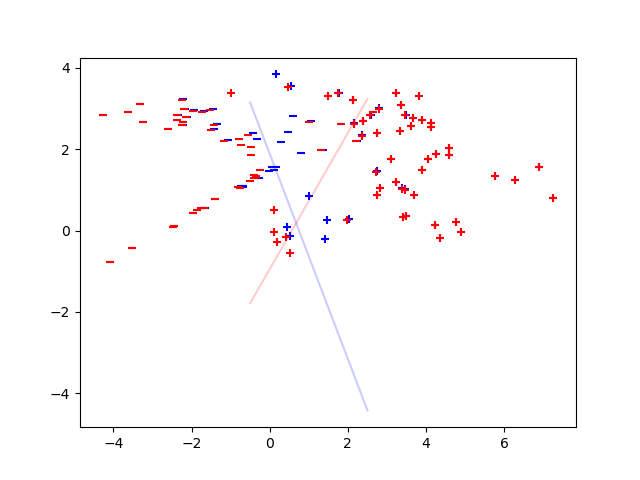

In [158]:
Xval_opt = non_strategic_model.optimize_X(Xval, evaluation=True)
print(non_strategic_model.evaluate(Xval, Yval))
print(strategic_model.evaluate(Xval, Yval))
print(non_strategic_model.evaluate(Xval_opt, Yval))
visualize_strategic_data(Xval, Xval_opt, Yval, non_strategic_model.w, non_strategic_model.b, strategic_model.w, strategic_model.b)

